In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multiple Layer GRU vs Conv

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow_datasets as tfds
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
# Get the data
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8F6R7C/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8F6R7C/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8F6R7C/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# note that the testing sequences are tokenized from the words learned in the training words
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [6]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


## Basic NN

In [7]:
base_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [8]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [9]:
base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
num_epochs = 50
base_history = base_model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 8s 6ms/step - loss: 0.5966 - accuracy: 0.6452 - val_loss: 0.3409 - val_accuracy: 0.8496
Epoch 2/50
782/782 [==============================] - 5s 6ms/step - loss: 0.2419 - accuracy: 0.9077 - val_loss: 0.3711 - val_accuracy: 0.8397
Epoch 3/50
782/782 [==============================] - 5s 6ms/step - loss: 0.0920 - accuracy: 0.9783 - val_loss: 0.4549 - val_accuracy: 0.8261
Epoch 4/50
782/782 [==============================] - 5s 6ms/step - loss: 0.0234 - accuracy: 0.9978 - val_loss: 0.5346 - val_accuracy: 0.8247
Epoch 5/50
782/782 [==============================] - 5s 6ms/step - loss: 0.0060 - accuracy: 0.9996 - val_loss: 0.6009 - val_accuracy: 0.8255
Epoch 6/50
782/782 [==============================] - 5s 6ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.6481 - val_accuracy: 0.8283
Epoch 7/50
782/782 [==============================] - 5s 6ms/step - loss: 9.2250e-04 - accuracy: 1.0000 - val_loss: 0.6921 - val_accuracy: 0.8296
Ep

## Conv1D

In [12]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


In [14]:
conv_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
num_epochs = 50
conv_history = conv_model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 36s 8ms/step - loss: 0.5423 - accuracy: 0.7048 - val_loss: 0.3486 - val_accuracy: 0.8474
Epoch 2/50
782/782 [==============================] - 6s 7ms/step - loss: 0.2699 - accuracy: 0.8924 - val_loss: 0.3559 - val_accuracy: 0.8460
Epoch 3/50
782/782 [==============================] - 6s 8ms/step - loss: 0.2073 - accuracy: 0.9225 - val_loss: 0.3950 - val_accuracy: 0.8363
Epoch 4/50
782/782 [==============================] - 6s 8ms/step - loss: 0.1744 - accuracy: 0.9383 - val_loss: 0.4180 - val_accuracy: 0.8312
Epoch 5/50
782/782 [==============================] - 6s 8ms/step - loss: 0.1361 - accuracy: 0.9562 - val_loss: 0.4765 - val_accuracy: 0.8232
Epoch 6/50
782/782 [==============================] - 6s 8ms/step - loss: 0.1099 - accuracy: 0.9655 - val_loss: 0.5228 - val_accuracy: 0.8175
Epoch 7/50
782/782 [==============================] - 6s 8ms/step - loss: 0.0860 - accuracy: 0.9754 - val_loss: 0.6167 - val_accuracy: 0.8150
Epoch

## BI-directional GRU

In [16]:
gru_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [17]:
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [18]:
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
num_epochs = 50
gru_history = gru_model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 17s 19ms/step - loss: 0.6716 - accuracy: 0.5748 - val_loss: 0.6262 - val_accuracy: 0.7018
Epoch 2/50
782/782 [==============================] - 14s 18ms/step - loss: 0.5789 - accuracy: 0.7232 - val_loss: 0.4692 - val_accuracy: 0.8030
Epoch 3/50
782/782 [==============================] - 14s 18ms/step - loss: 0.4356 - accuracy: 0.8232 - val_loss: 0.4192 - val_accuracy: 0.8350
Epoch 4/50
782/782 [==============================] - 14s 18ms/step - loss: 0.3344 - accuracy: 0.8837 - val_loss: 0.4089 - val_accuracy: 0.8373
Epoch 5/50
782/782 [==============================] - 14s 18ms/step - loss: 0.2713 - accuracy: 0.9104 - val_loss: 0.4043 - val_accuracy: 0.8389
Epoch 6/50
782/782 [==============================] - 14s 18ms/step - loss: 0.2266 - accuracy: 0.9300 - val_loss: 0.4582 - val_accuracy: 0.8332
Epoch 7/50
782/782 [==============================] - 14s 18ms/step - loss: 0.1927 - accuracy: 0.9424 - val_loss: 0.4569 - val_accuracy:

## BI-directional LSTM

In [20]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [21]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [22]:
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
num_epochs = 50
lstm_history = lstm_model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 18s 19ms/step - loss: 0.6624 - accuracy: 0.5762 - val_loss: 0.4329 - val_accuracy: 0.8156
Epoch 2/50
782/782 [==============================] - 15s 19ms/step - loss: 0.3428 - accuracy: 0.8621 - val_loss: 0.3432 - val_accuracy: 0.8521
Epoch 3/50
782/782 [==============================] - 15s 19ms/step - loss: 0.2379 - accuracy: 0.9122 - val_loss: 0.3582 - val_accuracy: 0.8437
Epoch 4/50
782/782 [==============================] - 15s 19ms/step - loss: 0.1738 - accuracy: 0.9382 - val_loss: 0.4192 - val_accuracy: 0.8396
Epoch 5/50
782/782 [==============================] - 15s 19ms/step - loss: 0.1122 - accuracy: 0.9621 - val_loss: 0.5242 - val_accuracy: 0.8296
Epoch 6/50
782/782 [==============================] - 15s 19ms/step - loss: 0.0718 - accuracy: 0.9750 - val_loss: 0.6611 - val_accuracy: 0.8084
Epoch 7/50
782/782 [==============================] - 14s 18ms/step - loss: 0.0477 - accuracy: 0.9856 - val_loss: 0.7413 - val_accuracy:

In [34]:
import matplotlib.pyplot as plt


def plot_graphs(history, title):
  # plt.plot(history.history[string])
  # plt.plot(history.history['val_'+string])
  # plt.xlabel("Epochs")
  # plt.ylabel(string)
  # plt.legend([string, 'val_'+string])
  # plt.show()

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
  
  ax1.plot(epochs, acc, label='Training acc')
  ax1.plot(epochs, val_acc, label='Validation acc')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.set_title(f'{title} Accuracy over {len(acc)} epochs')
  ax1.legend(loc=0)
  # ax1.legend(['legends', ''])
  
  ax2.plot(epochs, loss, label='Training loss')
  ax2.plot(epochs, val_loss, label='validation loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.set_title(f'{title} Loss over {len(acc)} epochs')
  ax2.legend(loc=0)

    
  plt.show()

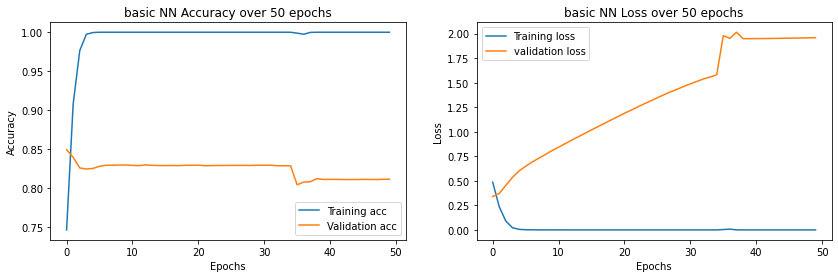

In [36]:
plot_graphs(base_history, 'basic NN')

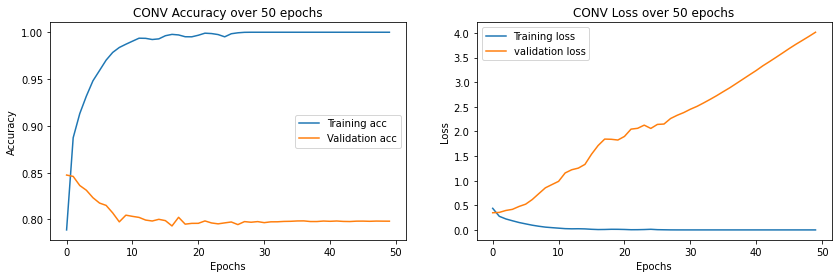

In [39]:
plot_graphs(conv_history, 'CONV')

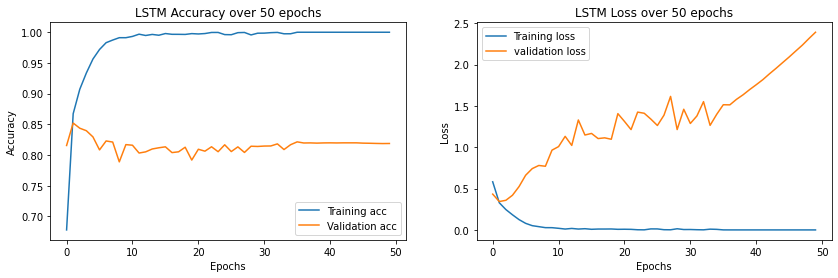

In [37]:
plot_graphs(lstm_history, 'LSTM')

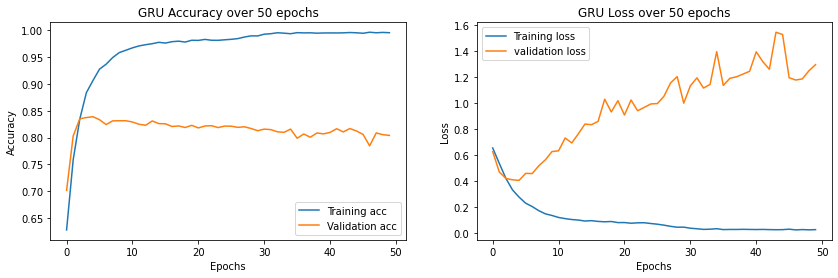

In [38]:
plot_graphs(gru_history, 'GRU')